<a href="https://colab.research.google.com/github/nyaagi/deitora_middle/blob/main/%E5%92%8C%E7%94%B0%E3%81%A1%E3%82%83%E3%82%93%E8%A7%A3%E6%9E%90%E6%AD%A3%E6%9B%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install streamlit -q

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import streamlit as st

%matplotlib inline

In [308]:
# データを読み込む
df = pd.read_csv('TNC.csv')

# 3列目以降のデータを取得し、数値の高いデータを選択する
selected_data = df.iloc[:, 2:].max().sort_values(ascending=False)[:10]

# 選択したデータをプロットする
"""
plt.plot(selected_data.index, selected_data.values, marker='o', linestyle='None')
plt.xticks(rotation=90)
plt.xlabel('Sample')
plt.ylabel('Expression level')
plt.title('Top 10 highest expression levels')
plt.show()
"""

"\nplt.plot(selected_data.index, selected_data.values, marker='o', linestyle='None')\nplt.xticks(rotation=90)\nplt.xlabel('Sample')\nplt.ylabel('Expression level')\nplt.title('Top 10 highest expression levels')\nplt.show()\n"

In [305]:
df.shape

(12011, 20)

In [22]:
def remove_any_zero_row(df):
    """全て0の行を削除"""
    df = df.copy()
    for row in df.index:
        if (df.loc[row] == 0).any():
            df.drop(row, axis=0, inplace=True)
    return df

In [51]:
def compare_to_threshold(df, threshold):
    """
    DataFrameの各要素がある数値より大きい場合にTrue、小さい場合にFalseを返す関数
    :param df: DataFrame
    :param threshold: しきい値
    :return: DataFrameの各要素がしきい値より大きい場合にTrue、小さい場合にFalseを持つDataFrame
    """
    return df > threshold

In [306]:
def remove_rows_greater_than_threshold(df, threshold):
    """
    DataFrameの各要素が行の平均値より大きい場合にTrue、小さい場合にFalseを返し、Trueが含まれる行を削除する関数
    :param df: DataFrame
    :param threshold: しきい値
    :return: Trueが含まれる行を削除した後のDataFrame、削除された行のインデックス
    """
    # 各行の平均を計算する
    med_series = df.median(axis=1)
    # 各要素が行の平均より大きい場合にTrue、小さい場合にFalseを返す
    bool_df = df > med_series.values.reshape(-1, 1) * threshold
    # Trueが含まれる行を削除する
    delete_index = bool_df.any(axis=1).loc[lambda x: x].index
    result = df.drop(delete_index)
    return result, delete_index

# DataFrameを定義
df = pd.DataFrame({'A': [1, 2, 4, 5], 'B': [6, 9, 40, 6], 'C': [3, 100, 20, 7], 'D': [4, 7, 2, 8]})

# しきい値を設定
threshold = 2

# 行を削除する
result, delete_index = remove_rows_greater_than_threshold(df, threshold)

# 結果を出力
print("削除された行のインデックス: ", delete_index)
print("DataFrame: ")
print(result)


削除された行のインデックス:  Int64Index([1, 2], dtype='int64')
DataFrame: 
   A  B  C  D
0  1  6  3  4
3  5  6  7  8


# BALBとB6の解析

In [309]:
df_mouse = df.iloc[:, :8]
#df_mouse = remove_any_zero_row(df_mouse)
df_mouse.columns = ['Gene', 'Target', 'BALB_1', 'BALB_2', 'BALB_3', 'B6_1', 'B6_2', 'B6_3']
df_mouse['BALB_mean'] = df_mouse.iloc[:, 1:4].mean(axis=1)
df_mouse['BALB_median'] = df_mouse.iloc[:, 1:4].median(axis=1)
df_mouse['BALB_std'] = df_mouse.iloc[:, 1:4].std(axis=1)
df_mouse['B6_mean'] = df_mouse.iloc[:, 4:7].mean(axis=1)
df_mouse['B6_median'] = df_mouse.iloc[:, 4:7].median(axis=1)
df_mouse['B6_std'] = df_mouse.iloc[:, 4:7].std(axis=1)
df_mouse.drop('Target', inplace=True, axis=1)
df_mouse.shape
#df_mouse.drop(columns=['IonXpress_001', 'IonXpress_002', 'IonXpress_003', 'IonXpress_004', 'IonXpress_005', 'IonXpress_006'], axis=0, inplace=True)

<ipython-input-309-e8c377181cca>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_mouse['BALB_mean'] = df_mouse.iloc[:, 1:4].mean(axis=1)
<ipython-input-309-e8c377181cca>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_mouse['BALB_median'] = df_mouse.iloc[:, 1:4].median(axis=1)
<ipython-input-309-e8c377181cca>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_mouse['BALB_std'] = df_mouse.iloc[:, 1:4].std(axis=1)


(23930, 13)

In [314]:
# 遺伝子発現が10以下は削除とする。
df_mouse = df_mouse.query("BALB_mean >= 10 and B6_mean >= 10").reset_index(drop=True)
# t検定を実行する
df_mouse['t_stat'], df_mouse['p_val'] = stats.ttest_ind(df_mouse[['BALB_1', 'BALB_2', 'BALB_3']], df_mouse[['B6_1', 'B6_2', 'B6_3']], axis=1)
# 結果を表示する
#print('t-value:', df_mouse['t_stat'])
#print('p-value:', df_mouse['p_val'])
#df_mouse_stat = df_mouse.query('p_val < 0.05')
#df_mouse_stat.sort_values(by='p_val')
df_mouse.head()

<ipython-input-314-77217e825398>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_mouse['t_stat'], df_mouse['p_val'] = stats.ttest_ind(df_mouse[['BALB_1', 'BALB_2', 'BALB_3']], df_mouse[['B6_1', 'B6_2', 'B6_3']], axis=1)


,Gene,BALB_1,BALB_2,BALB_3,B6_1,B6_2,B6_3,BALB_mean,BALB_median,BALB_std,B6_mean,B6_median,B6_std,BALB/B6,B6/BALB,t_stat,p_val
0,0610005C13Rik,59,24,17,31,42,32,41.5,41.5,24.748737,30.000000,31.0,12.529964,1.383333,0.722892,-0.123844,0.907412
1,2310011J03Rik,174,187,206,230,236,298,180.5,180.5,9.192388,224.000000,230.0,15.874508,0.805804,1.240997,-2.777956,0.049923
2,2510009E07Rik,236,368,341,270,311,274,302.0,302.0,93.338095,307.333333,311.0,35.641736,0.982646,1.017660,0.708815,0.517565
3,2500002B13Rik,119,234,202,100,120,126,176.5,176.5,81.317280,140.666667,120.0,54.049360,1.254739,0.796978,1.981510,0.118597
4,4732491K20Rik,32,28,11,24,40,19,30.0,30.0,2.828427,25.000000,24.0,14.525839,1.200000,0.833333,-0.442928,0.680717


In [315]:
# 発現比を比較する
df_mouse['BALB/B6'] = df_mouse['BALB_mean'] / df_mouse['B6_mean']
Data_balb_high = df_mouse['BALB/B6'].sort_values(ascending=False).head(30)

df_mouse['B6/BALB'] = df_mouse['B6_mean'] / df_mouse['BALB_mean']
Data_b6_high = df_mouse['B6/BALB'].sort_values(ascending=False).head(30)

In [316]:
# 中央値から5倍以上はなれた数値を含むものは、削除対象。
threshold = 5
result, delete_index = remove_rows_greater_than_threshold(df_mouse[['BALB_1', 'BALB_2', 'BALB_3']], threshold)
print("削除された行のインデックス: ", delete_index)
print(df_mouse.shape)
df_mouse.drop(delete_index, inplace=True)

result, delete_index = remove_rows_greater_than_threshold(df_mouse[['B6_1', 'B6_2', 'B6_3']], threshold)
print("削除された行のインデックス: ", delete_index)
print(df_mouse.shape)
df_mouse.drop(delete_index, inplace=True)
print(df_mouse.shape)

削除された行のインデックス:  Int64Index([], dtype='int64')
(12871, 17)
削除された行のインデックス:  Int64Index([], dtype='int64')
(12871, 17)
(12871, 17)


In [317]:
display(df_mouse.head())
df_mouse.describe().T.style.background_gradient(cmap='YlOrRd')

,Gene,BALB_1,BALB_2,BALB_3,B6_1,B6_2,B6_3,BALB_mean,BALB_median,BALB_std,B6_mean,B6_median,B6_std,BALB/B6,B6/BALB,t_stat,p_val
0,0610005C13Rik,59,24,17,31,42,32,41.5,41.5,24.748737,30.000000,31.0,12.529964,1.383333,0.722892,-0.123844,0.907412
1,2310011J03Rik,174,187,206,230,236,298,180.5,180.5,9.192388,224.000000,230.0,15.874508,0.805804,1.240997,-2.777956,0.049923
2,2510009E07Rik,236,368,341,270,311,274,302.0,302.0,93.338095,307.333333,311.0,35.641736,0.982646,1.017660,0.708815,0.517565
3,2500002B13Rik,119,234,202,100,120,126,176.5,176.5,81.317280,140.666667,120.0,54.049360,1.254739,0.796978,1.981510,0.118597
4,4732491K20Rik,32,28,11,24,40,19,30.0,30.0,2.828427,25.000000,24.0,14.525839,1.200000,0.833333,-0.442928,0.680717


,count,mean,std,min,25%,50%,75%,max
BALB_1,12871.000000,1007.960920,3709.748988,0.000000,116.000000,383.000000,948.000000,198955.000000
BALB_2,12871.000000,1020.738404,4092.760281,1.000000,104.000000,341.000000,905.000000,251772.000000
BALB_3,12871.000000,1068.138684,4564.114820,0.000000,96.000000,338.000000,919.000000,278590.000000
B6_1,12871.000000,992.747184,4052.320453,0.000000,113.000000,357.000000,880.000000,206763.000000
B6_2,12871.000000,1030.052677,4215.868276,0.000000,103.000000,345.000000,897.500000,214212.000000
B6_3,12871.000000,1116.208453,4477.068597,0.000000,116.000000,389.000000,970.000000,233724.000000
BALB_mean,12871.000000,1014.349662,3824.050616,10.000000,116.750000,371.000000,939.500000,223991.000000
BALB_median,12871.000000,1014.349662,3824.050616,10.000000,116.750000,371.000000,939.500000,223991.000000
BALB_std,12871.000000,233.353424,1100.827705,0.000000,16.970563,56.568542,161.927453,41223.618236
B6_mean,12871.000000,1030.312848,4177.113471,10.000000,111.000000,355.000000,909.833333,233188.333333


## 関連するpathwayのgeneを列挙してみる。 PubchemからExtracellular matrix organizationで検索

In [318]:
pathway = pd.read_csv('/content/Pathway_ECM_mus.csv')
pathway['genesymbol'] = pathway['genesymbol'].str.capitalize()

# 遺伝子名をリストにして、今回のNGS結果から検索をかけてみる。さらにp値でソートして、トップ20を検出
genename = pathway['genesymbol'].tolist()
ECMpath = df_mouse[df_mouse['Gene'].isin(genename)]
print(ECMpath.shape)

df_mouse[df_mouse['Gene'].isin(genename)].sort_values(by='p_val').head(20)

(97, 17)


,Gene,BALB_1,BALB_2,BALB_3,B6_1,B6_2,B6_3,BALB_mean,BALB_median,BALB_std,B6_mean,B6_median,B6_std,BALB/B6,B6/BALB,t_stat,p_val
3607,Eln,167,226,143,745,790,827,196.5,196.5,41.719300,559.333333,745.0,361.256603,0.351311,2.846480,-17.792843,0.000059
5340,Itga4,410,481,398,797,808,859,445.5,445.5,50.204581,667.666667,797.0,233.602939,0.667249,1.498691,-12.171102,0.000262
5341,Itga2,1493,1466,1625,1001,1012,1085,1479.5,1479.5,19.091883,1212.666667,1012.0,357.133495,1.220038,0.819646,8.885310,0.000886
5119,Itgae,42,40,53,8,12,16,41.0,41.0,1.414214,24.333333,12.0,24.906492,1.684932,0.593496,7.089537,0.002090
2936,Col24a1,185,310,141,637,688,573,247.5,247.5,88.388348,488.666667,637.0,302.166069,0.506480,1.974411,-6.944767,0.002258
5116,Itgal,268,341,384,596,562,620,304.5,304.5,51.618795,514.000000,562.0,113.859563,0.592412,1.688013,-6.920935,0.002287
5111,Itgax,291,403,507,1077,1114,879,347.0,347.0,79.195959,899.333333,1077.0,340.273909,0.385841,2.591739,-6.491031,0.002905
4291,Fbn1,1592,1549,1286,2983,3141,4006,1570.5,1570.5,30.405592,2470.000000,2983.0,1028.412855,0.635830,1.572748,-5.725413,0.004607
2941,Crtap,2960,3116,2849,3491,3377,3464,3038.0,3038.0,110.308658,3239.000000,3377.0,342.525911,0.937944,1.066162,-5.534911,0.005208
4021,Fbln2,7984,10683,8627,13192,16143,14331,9333.5,9333.5,1908.481202,12654.000000,13192.0,3786.772636,0.737593,1.355762,-4.610985,0.009948


In [23]:
# focal adhesion PI3K-Akt-mTOR signaling pathwayに含まれる遺伝子
"""
pathway = pd.read_csv('/content/Pathwayfocalsad_mus.csv')
pathway['genesymbol'] = pathway['genesymbol'].str.capitalize()
genename2 = pathway['genesymbol'].tolist()

for name in genename:
    if name in genename2:
        print(name)
"""
#　共通のものは多くない。

## まずは、遺伝子の発現量をプロット。
大抵は、10^3周辺の発現量である。大きな違いはみられない。

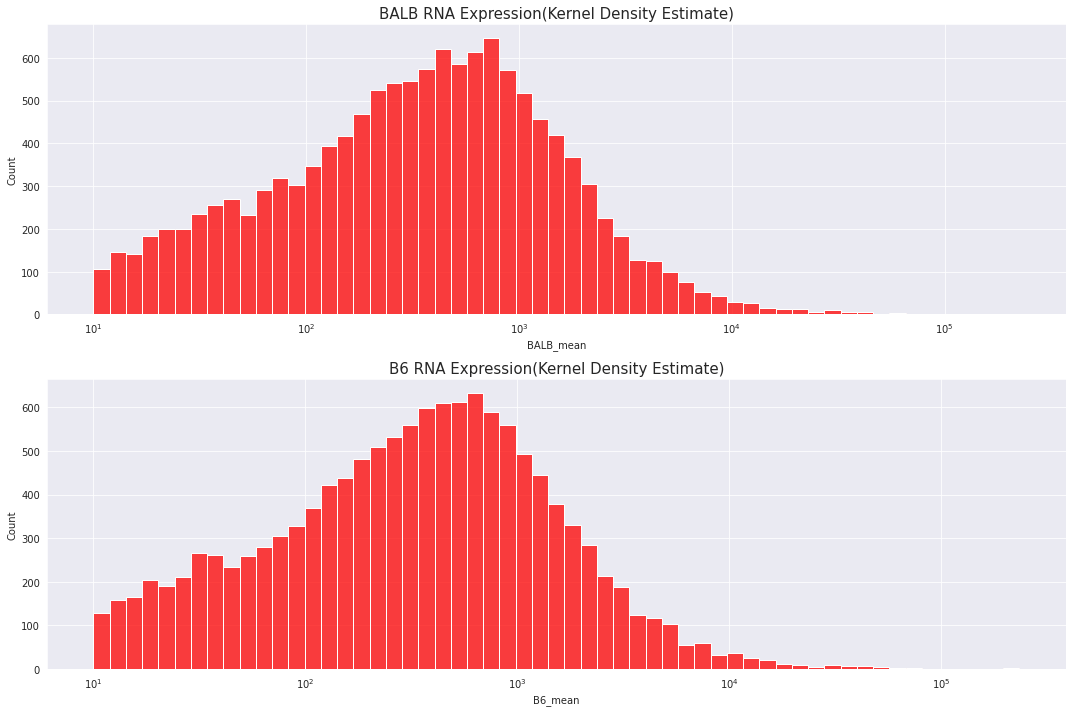

In [319]:
# データのグラフ化。おそらく数値がおおきければ、対数変換がよいかも。
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), tight_layout=True)

sns.set_style('darkgrid')

_ = sns.histplot(df_mouse['BALB_mean'], fill=True, color='r', ax=axs[0], label='BALB RNA Expression', log_scale=True)
_ = axs[0].set_title('BALB RNA Expression(Kernel Density Estimate)', fontsize=15)

_ = sns.histplot(df_mouse['B6_mean'], fill=True, color='r', ax=axs[1], label='B6 RNA expression', log_scale=True)
_ = axs[1].set_title('B6 RNA Expression(Kernel Density Estimate)', fontsize=15)

### 遺伝子ごとに比較。
BALBは53倍程度おおいものがある。
B6はserpina1を除くと180倍まである。

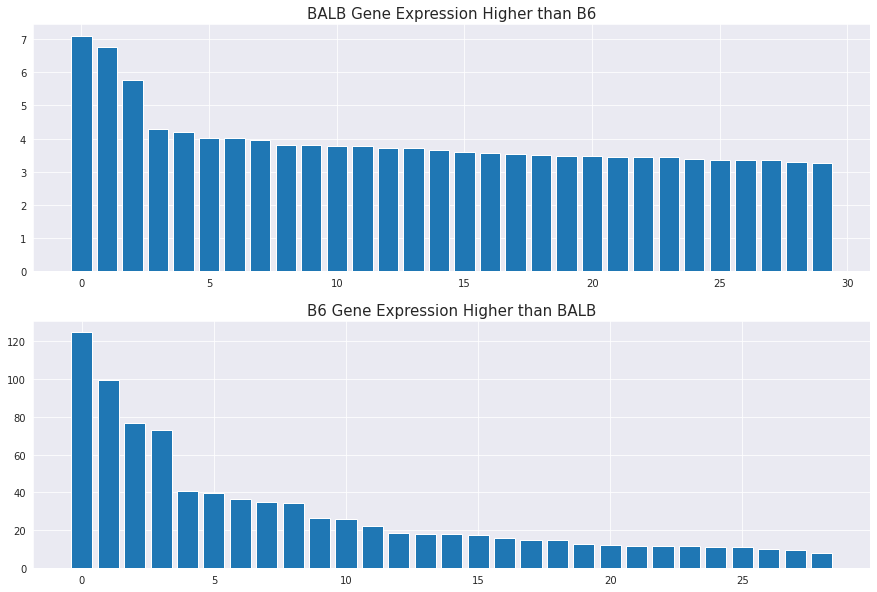

In [320]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = axs[0].bar(x=range(30), height=Data_balb_high)
_ = axs[0].set_title('BALB Gene Expression Higher than B6', fontsize=15)

_ = axs[1].bar(x=range(29), height=Data_b6_high[1:])
_ = axs[1].set_title('B6 Gene Expression Higher than BALB', fontsize=15)

plt.show()

# Serpina1は桁が大きいため、表からは削除した。

### t検定を追加して、散布図に描写。有意差0.05を基準にして、p値がでるものは色を変更する。

めちゃ重いため、時間がかかる。

<ipython-input-272-308b425bcbc9>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = stats.ttest_ind(df_mouse_copy[['BALB_1', 'BALB_2', 'BALB_3']], df_mouse_copy[['B6_1', 'B6_2', 'B6_3']], axis=1, equal_var=True)


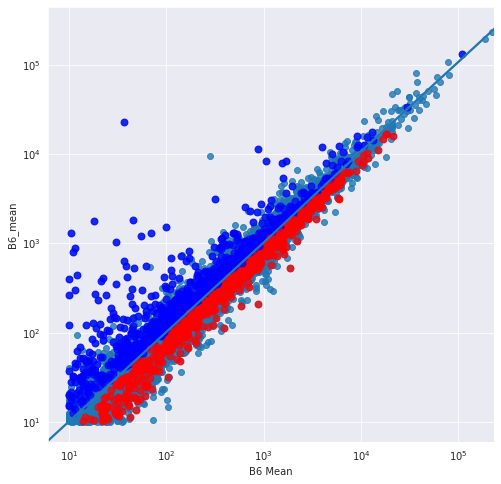

In [272]:
# 遺伝子名をインデックスに設定
df_mouse_copy = df_mouse.copy()

t, p = stats.ttest_ind(df_mouse_copy[['BALB_1', 'BALB_2', 'BALB_3']], df_mouse_copy[['B6_1', 'B6_2', 'B6_3']], axis=1, equal_var=True)
alpha = 0.05

# プロットする
plt.figure(figsize=(8, 8))
  
sns.regplot(x='BALB_mean', y='B6_mean', truncate=False, data=df_mouse_copy)
plt.xlabel('BALB Mean')
plt.xlabel('B6 Mean')
plt.xscale('log')
plt.yscale('log')
 #sns.regplot(x=mean_a, y=mean_b, fit_reg=False)
 #plt.xlabel('Group A Mean')
 #plt.xlabel('Group A Mean')

# 赤い点と青い点で分けてプロットする
significant_genes = []
for i, gene in enumerate(df_mouse_copy.index):
    if p[i] < alpha:
        if df_mouse['BALB_mean'].iloc[i] > df_mouse_copy['B6_mean'].iloc[i]:
            plt.scatter(df_mouse_copy['BALB_mean'].iloc[i], df_mouse_copy['B6_mean'].iloc[i], color='red', s=50, alpha=0.7)
            significant_genes.append((gene, 'BALB'))
        else:
            plt.scatter(df_mouse_copy['BALB_mean'].iloc[i], df_mouse_copy['B6_mean'].iloc[i], color='blue', s=50, alpha=0.7)
            significant_genes.append((gene, 'B6'))

## 最初にだしたECM pathwayに関連した遺伝子のみをつかっていみる。

p値がでるものは20個あるようだ。

In [321]:
ECMpath[['p_val']].query('p_val <= 0.05').count()
display(ECMpath[['Gene', 'BALB_mean', 'B6_mean', 'BALB/B6', 'p_val']].query('p_val <= 0.05').sort_values(by='p_val'))

,Gene,BALB_mean,B6_mean,BALB/B6,p_val
3607,Eln,196.5,559.333333,0.351311,0.000059
5340,Itga4,445.5,667.666667,0.667249,0.000262
5341,Itga2,1479.5,1212.666667,1.220038,0.000886
5119,Itgae,41.0,24.333333,1.684932,0.002090
2936,Col24a1,247.5,488.666667,0.506480,0.002258
5116,Itgal,304.5,514.000000,0.592412,0.002287
5111,Itgax,347.0,899.333333,0.385841,0.002905
4291,Fbn1,1570.5,2470.000000,0.635830,0.004607
2941,Crtap,3038.0,3239.000000,0.937944,0.005208
4021,Fbln2,9333.5,12654.000000,0.737593,0.009948


## 結論：何か参考になればいいけれど。

# 次にWT、KOの病変を解析してみる。
## 病変からいきます。

In [330]:
df_gene = df['Gene']
df_mouse = df.iloc[:, 8:14]
# df_mosue = remove_any_zero_row(df_mouse)
df_mouse = pd.concat([df_gene, df_mouse], axis=1)
df_mouse.columns = ['Gene', 'KO_1', 'KO_2', 'KO_3', 'WT_1', 'WT_2', 'WT_3']
df_mouse['KO_mean'] = df_mouse.iloc[:, 1:4].mean(axis=1)
df_mouse['KO_std'] = df_mouse.iloc[:, 1:4].std(axis=1)
df_mouse['WT_mean'] = df_mouse.iloc[:, 4:7].mean(axis=1)
df_mouse['WT_std'] = df_mouse.iloc[:, 4:7].std(axis=1)

In [331]:
# 遺伝子発現が10以下は削除とする。
df_mouse = df_mouse.query("KO_mean >= 10 and WT_mean >= 10").reset_index(drop=True)
# t検定を実行する
df_mouse['t_stat'], df_mouse['p_val'] = stats.ttest_ind(df_mouse[['KO_1', 'KO_2', 'KO_3']], df_mouse[['WT_1', 'WT_2', 'WT_3']], axis=1)
# 結果を表示する
#print('t-value:', df_mouse['t_stat'])
#print('p-value:', df_mouse['p_val'])
#df_mouse_stat = df_mouse.query('p_val < 0.05')
#df_mouse_stat.sort_values(by='p_val')

<ipython-input-331-c93080922b80>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_mouse['t_stat'], df_mouse['p_val'] = stats.ttest_ind(df_mouse[['KO_1', 'KO_2', 'KO_3']], df_mouse[['WT_1', 'WT_2', 'WT_3']], axis=1)


In [332]:
# 発現比を比較する
df_mouse['KO_div_by_WT'] = df_mouse['KO_mean'] / df_mouse['WT_mean']
Data_KO_high = df_mouse['KO_div_by_WT'].sort_values(ascending=False).head(30)

df_mouse['WT_div_by_KO'] = df_mouse['WT_mean'] / df_mouse['KO_mean']
Data_WT_high = df_mouse['WT_div_by_KO'].sort_values(ascending=False).head(30)

In [333]:
threshold = 5
print(df_mouse.shape)

result, delete_index = remove_rows_greater_than_threshold(df_mouse[['KO_1', 'KO_2', 'KO_3']], threshold)
print("削除された行のインデックス: ", delete_index)

df_mouse.drop(delete_index, inplace=True)

result, delete_index = remove_rows_greater_than_threshold(df_mouse[['WT_1', 'WT_2', 'WT_3']], threshold)
print("削除された行のインデックス: ", delete_index)

df_mouse.drop(delete_index, inplace=True)
print(df_mouse.shape)

(12982, 15)
削除された行のインデックス:  Int64Index([   79,   158,   183,   251,   278,   288,   399,   477,   641,
              834,
            ...
            12208, 12343, 12360, 12504, 12560, 12572, 12668, 12776, 12883,
            12921],
           dtype='int64', length=152)
削除された行のインデックス:  Int64Index([   12,    44,   369,   407,   429,   461,   770,   811,   864,
              887,  1004,  1056,  1325,  1360,  1427,  1822,  2270,  2280,
             2764,  3033,  3866,  4063,  4798,  5061,  5091,  5120,  5260,
             5337,  5386,  5512,  5548,  5805,  5834,  6426,  6433,  6485,
             6517,  6518,  6618,  6643,  6776,  6828,  6976,  7011,  7436,
             7450,  7472,  7585,  7795,  7798,  7945,  8493,  8731,  8956,
             9068,  9540,  9748,  9877, 10370, 10428, 10456, 10527, 10584,
            10658, 10736, 10743, 10800, 10810, 11022, 12448, 12701],
           dtype='int64')
(12759, 15)


In [334]:
# df_mouse[df_mouse['Gene'].str.contains('Lyz')]

In [335]:
display(df_mouse.head())
df_mouse.describe().T.style.background_gradient(cmap='YlOrRd')

,Gene,KO_1,KO_2,KO_3,WT_1,WT_2,WT_3,KO_mean,KO_std,WT_mean,WT_std,t_stat,p_val,KO_div_by_WT,WT_div_by_KO
0,0610005C13Rik,29,14,43,24,36,36,28.666667,14.502873,32.000000,6.928203,-0.359211,0.737597,0.895833,1.116279
1,2310011J03Rik,128,123,113,155,124,181,121.333333,7.637626,153.333333,28.536526,-1.876231,0.133863,0.791304,1.263736
2,2510009E07Rik,328,350,402,268,353,227,360.000000,38.000000,282.666667,64.267669,1.794035,0.147257,1.273585,0.785185
3,2500002B13Rik,113,209,75,79,79,77,132.333333,69.060360,78.333333,1.154701,1.354144,0.247138,1.689362,0.591940
4,4732491K20Rik,29,18,51,46,52,26,32.666667,16.802778,41.333333,13.613719,-0.694136,0.525802,0.790323,1.265306


,count,mean,std,min,25%,50%,75%,max
KO_1,12759.000000,906.677483,3531.680221,2.000000,96.000000,304.000000,798.500000,203026.000000
KO_2,12759.000000,882.383181,3850.115762,0.000000,82.000000,275.000000,753.500000,250147.000000
KO_3,12759.000000,831.770515,3404.337263,0.000000,102.000000,309.000000,758.000000,186643.000000
WT_1,12759.000000,979.386864,4280.940088,1.000000,106.000000,328.000000,832.000000,238653.000000
WT_2,12759.000000,1026.924132,4803.603871,1.000000,118.000000,358.000000,893.000000,310281.000000
WT_3,12759.000000,929.546046,4017.939902,3.000000,106.000000,323.000000,800.500000,231985.000000
KO_mean,12759.000000,873.610393,3486.115787,10.000000,97.666667,300.333333,778.333333,198370.000000
KO_std,12759.000000,194.339577,1084.905169,0.000000,19.295941,51.733290,130.817935,54255.043793
WT_mean,12759.000000,978.619014,4343.519449,10.000000,111.666667,340.333333,849.166667,260306.333333
WT_std,12759.000000,143.330435,674.561964,0.000000,16.041613,43.293572,113.328427,43407.557376


## 関連するpathwayのgeneを列挙してみる。 PubchemからExtracellular matrix organizationで検索

In [336]:
# 遺伝子名をリストにして、今回のNGS結果から検索をかけてみる。さらにp値でソートして、トップ20を検出
ECMpath = df_mouse[df_mouse['Gene'].isin(genename)]

df_mouse[df_mouse['Gene'].isin(genename)].sort_values(by='p_val').head(20)

,Gene,KO_1,KO_2,KO_3,WT_1,WT_2,WT_3,KO_mean,KO_std,WT_mean,WT_std,t_stat,p_val,KO_div_by_WT,WT_div_by_KO
99,Col4a2,3883,4238,3979,5740,5957,6103,4033.333333,183.630971,5933.333333,182.653588,-12.706006,0.000221,0.679775,1.471074
2865,Ddr1,448,497,420,696,741,729,455.000000,38.974351,722.000000,23.302360,-10.184215,0.000524,0.630194,1.586813
426,Spp1,16368,14429,13598,30197,27993,25936,14798.333333,1421.453599,28042.000000,2130.922570,-8.955130,0.000860,0.527720,1.894943
2821,Col5a1,4482,4851,6174,9606,10059,10676,5169.000000,889.696016,10113.666667,537.090619,-8.241014,0.001182,0.511091,1.956600
8082,Prkca,204,183,197,314,275,306,194.666667,10.692677,298.333333,20.599353,-7.736414,0.001503,0.652514,1.532534
4358,Fbn1,1525,1792,3112,5154,5488,5124,2143.000000,849.731134,5255.333333,202.052798,-6.171943,0.003500,0.407776,2.452325
3667,Eln,490,584,972,1909,1532,1953,682.000000,255.507338,1798.000000,231.410890,-5.607285,0.004969,0.379310,2.636364
6329,Mmp12,6055,6091,5045,2678,3812,2901,5730.333333,593.788964,3130.333333,600.778107,5.331274,0.005960,1.830582,0.546274
2929,Ddr2,916,939,1024,1150,1287,1221,959.666667,56.888780,1219.333333,68.515205,-5.050356,0.007229,0.787042,1.270580
4081,Fbln2,10012,11096,12461,17681,24567,23168,11189.666667,1227.183904,21805.333333,3639.628324,-4.787068,0.008730,0.513162,1.948703


## まずは、遺伝子の発現量をプロット。
大抵は、10^2 ~ 10^3の発現量である。大きな違いはみられない。

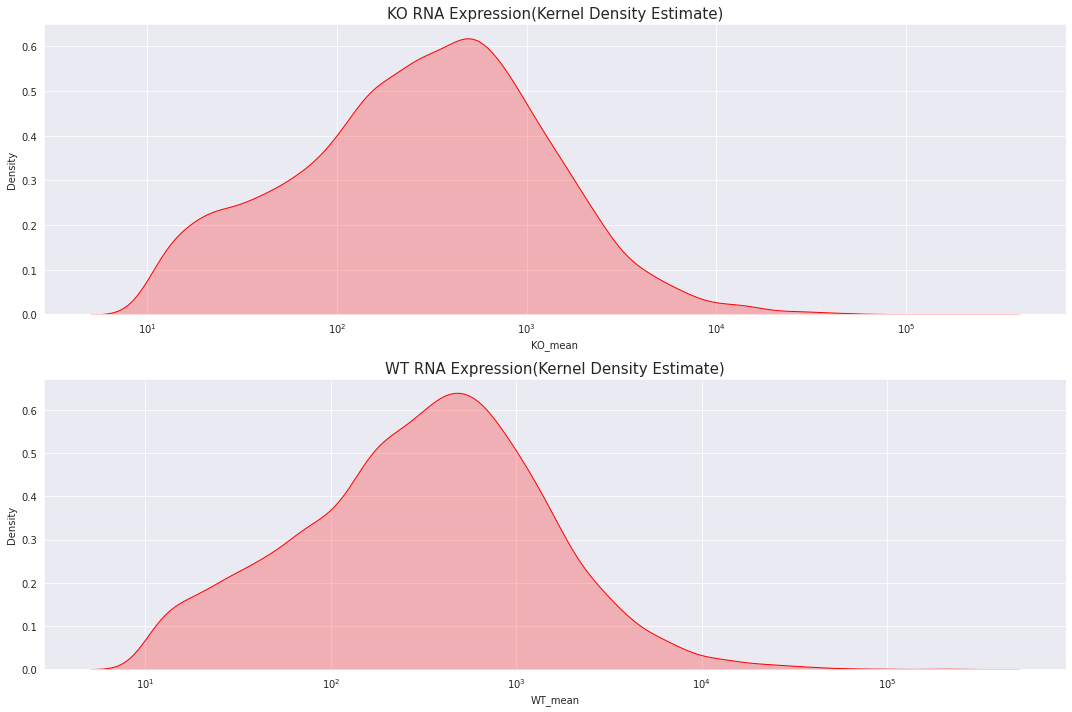

In [337]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), tight_layout=True)

sns.set_style('darkgrid')

_ = sns.kdeplot(df_mouse['KO_mean'], fill=True, color='r', ax=axs[0], label='KO RNA Expression', log_scale=True)
_ = axs[0].set_title('KO RNA Expression(Kernel Density Estimate)', fontsize=15)

_ = sns.kdeplot(df_mouse['WT_mean'], fill=True, color='r', ax=axs[1], label='WT RNA expression', log_scale=True)
_ = axs[1].set_title('WT RNA Expression(Kernel Density Estimate)', fontsize=15)

In [338]:
df_mouse.sort_values(by='KO_div_by_WT').head(20)

,Gene,KO_1,KO_2,KO_3,WT_1,WT_2,WT_3,KO_mean,KO_std,WT_mean,WT_std,t_stat,p_val,KO_div_by_WT,WT_div_by_KO
6477,Nfasc,13,13,63,322,484,639,29.666667,28.867513,481.666667,158.512881,-4.859029,0.008285,0.061592,16.235955
2719,Ccl8,57,124,147,1562,665,2614,109.333333,46.758243,1613.666667,975.526695,-2.667886,0.055929,0.067755,14.759146
2320,Chl1,161,220,313,1526,1876,3595,231.333333,76.631151,2332.333333,1107.416062,-3.278223,0.030552,0.099185,10.082133
2317,Ccl12,40,40,75,754,344,404,51.666667,20.207259,500.666667,221.434716,-3.497522,0.024952,0.103196,9.690323
8923,Scn7a,17,3,72,255,183,428,30.666667,36.473735,288.666667,125.921933,-3.408666,0.027061,0.106236,9.413043
4931,Il11ra1,238,67,118,1516,1020,1382,141.000000,87.789521,1306.000000,256.585268,-7.440736,0.001742,0.107963,9.262411
11205,Xpnpep2,11,8,11,61,73,136,10.000000,1.732051,90.000000,40.286474,-3.436294,0.026383,0.111111,9.000000
4038,Fabp4,200,274,346,2298,1479,3537,273.333333,73.002283,2438.000000,1036.118236,-3.609666,0.022563,0.112114,8.919512
11979,Wisp2,5,11,29,232,67,85,15.000000,12.489996,128.000000,90.515192,-2.142012,0.098864,0.117188,8.533333
10552,Tnc,1987,2553,837,13081,21978,10456,1792.333333,874.405703,15171.666667,6038.814978,-3.797849,0.019139,0.118137,8.464757


## 遺伝子ごとに比較。
KOで多くなる遺伝子って、ほとんどが3倍という

WTでおおくなる遺伝子は、多くて8倍。あとは、ほぼ3倍程度。

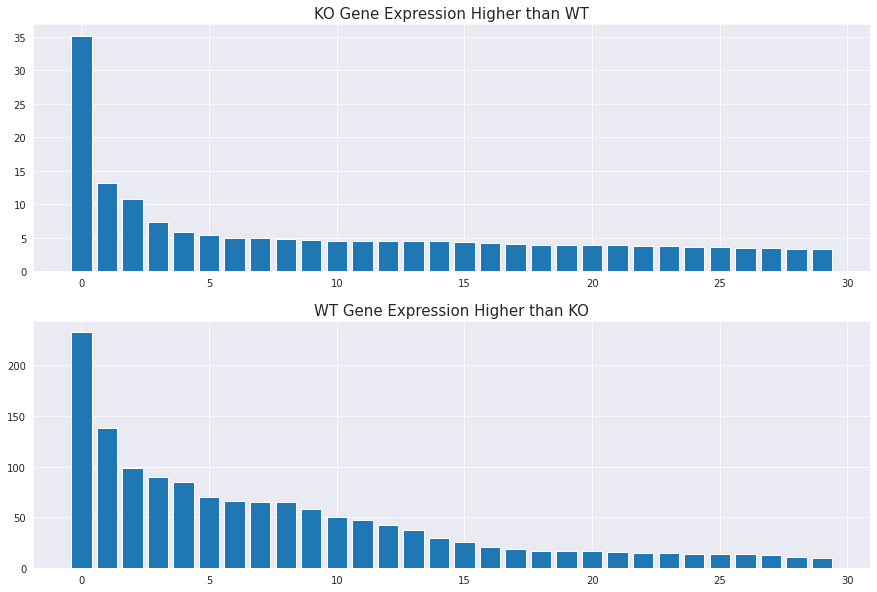

In [339]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = axs[0].bar(x=range(30), height=Data_KO_high)
_ = axs[0].set_title('KO Gene Expression Higher than WT', fontsize=15)

_ = axs[1].bar(x=range(30), height=Data_WT_high)
_ = axs[1].set_title('WT Gene Expression Higher than KO', fontsize=15)

plt.show()

## t検定を追加して、散布図に描写。有意差0.05を基準にして、p値がでるものは色を変更する。

<ipython-input-191-4a0ae9f9dffa>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = stats.ttest_ind(df_mouse_copy[['KO_1', 'KO_2', 'KO_3']], df_mouse_copy[['WT_1', 'WT_2', 'WT_3']], axis=1, equal_var=True)


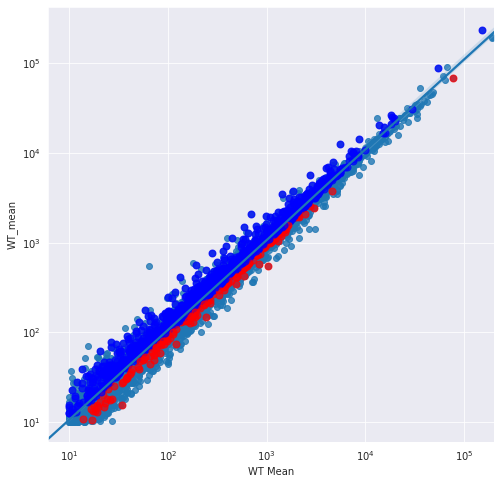

In [191]:
# 遺伝子名をインデックスに設定
df_mouse_copy = df_mouse.copy()

t, p = stats.ttest_ind(df_mouse_copy[['KO_1', 'KO_2', 'KO_3']], df_mouse_copy[['WT_1', 'WT_2', 'WT_3']], axis=1, equal_var=True)
alpha = 0.05

# プロットする
plt.figure(figsize=(8, 8))
  
sns.regplot(x='KO_mean', y='WT_mean', truncate=False, data=df_mouse_copy)
plt.xlabel('KO Mean')
plt.xlabel('WT Mean')
plt.xscale('log')
plt.yscale('log')

 #sns.regplot(x=mean_a, y=mean_b, fit_reg=False)
 #plt.xlabel('Group A Mean')
 #plt.xlabel('Group A Mean')

# 赤い点と青い点で分けてプロットする
significant_genes = []
for i, gene in enumerate(df_mouse_copy.index):
    if p[i] < alpha:
        if df_mouse['KO_mean'].iloc[i] > df_mouse_copy['WT_mean'].iloc[i]:
            plt.scatter(df_mouse_copy['KO_mean'].iloc[i], df_mouse_copy['WT_mean'].iloc[i], color='red', s=50, alpha=0.7)
            significant_genes.append((gene, 'KO'))
        else:
            plt.scatter(df_mouse_copy['KO_mean'].iloc[i], df_mouse_copy['WT_mean'].iloc[i], color='blue', s=50, alpha=0.7)
            significant_genes.append((gene, 'WT'))

In [192]:
print(len(significant_genes))

2005


In [340]:
# 統計学的に有意な遺伝子を上位30で書き出す。
df_mouse_cyst = df_mouse[['Gene', 'KO_mean', 'WT_mean', 'KO_div_by_WT', 'p_val']].query('p_val <= 0.05')
df_mouse_cyst = df_mouse_cyst.query('KO_div_by_WT >= 2 or KO_div_by_WT <= 0.5')
display(df_mouse_cyst.sort_values(by='KO_div_by_WT', ascending=True).head(15))
display(df_mouse_cyst.sort_values(by='KO_div_by_WT', ascending=False).head(15))

,Gene,KO_mean,WT_mean,KO_div_by_WT,p_val
6477,Nfasc,29.666667,481.666667,0.061592,0.008285
2320,Chl1,231.333333,2332.333333,0.099185,0.030552
2317,Ccl12,51.666667,500.666667,0.103196,0.024952
8923,Scn7a,30.666667,288.666667,0.106236,0.027061
4931,Il11ra1,141.000000,1306.000000,0.107963,0.001742
11205,Xpnpep2,10.000000,90.000000,0.111111,0.026383
4038,Fabp4,273.333333,2438.000000,0.112114,0.022563
10552,Tnc,1792.333333,15171.666667,0.118137,0.019139
9928,Svep1,137.333333,1082.333333,0.126886,0.005619
6338,Mrap,24.333333,185.000000,0.131532,0.004628


,Gene,KO_mean,WT_mean,KO_div_by_WT,p_val
249,Lyz1,1375.666667,304.000000,4.525219,0.000219
8012,Pigr,389.000000,102.000000,3.813725,0.031886
2630,Cd226,33.000000,10.333333,3.193548,0.013420
739,4933431G14Rik,34.333333,11.333333,3.029412,0.021638
5530,Lef1,142.666667,51.000000,2.797386,0.013282
546,4930447M23Rik,27.000000,10.000000,2.700000,0.030158
9173,Sall1,74.000000,30.000000,2.466667,0.019242
12629,Gm32448,250.333333,105.666667,2.369085,0.011559
1478,Aldh1a3,1021.000000,446.333333,2.287528,0.031918
1043,Alad,613.333333,273.666667,2.241169,0.027678


### ECM pathwayに関連した遺伝子のみをつかっていみる。

In [341]:
ECMpath[['p_val']].query('p_val <= 0.05').count()
display(ECMpath[['Gene', 'KO_mean', 'WT_mean', 'KO_div_by_WT', 'p_val']].query('p_val <= 0.05').sort_values(by='p_val'))

,Gene,KO_mean,WT_mean,KO_div_by_WT,p_val
99,Col4a2,4033.333333,5933.333333,0.679775,0.000221
2865,Ddr1,455.000000,722.000000,0.630194,0.000524
426,Spp1,14798.333333,28042.000000,0.527720,0.000860
2821,Col5a1,5169.000000,10113.666667,0.511091,0.001182
8082,Prkca,194.666667,298.333333,0.652514,0.001503
4358,Fbn1,2143.000000,5255.333333,0.407776,0.003500
3667,Eln,682.000000,1798.000000,0.379310,0.004969
6329,Mmp12,5730.333333,3130.333333,1.830582,0.005960
2929,Ddr2,959.666667,1219.333333,0.787042,0.007229
4081,Fbln2,11189.666667,21805.333333,0.513162,0.008730


### 発現にp値がでていても、遺伝子比は2倍にいかないものもおおい。そのため、>2倍もしくは<0.5倍でソートする。

In [342]:
ECMpath_cyst = ECMpath[['Gene', 'KO_mean', 'WT_mean', 'KO_div_by_WT', 'p_val']].query('p_val <= 0.05')
ECMpath_cyst = ECMpath_cyst.query('KO_div_by_WT >= 2 or KO_div_by_WT <= 0.5')
ECMpath_cyst

,Gene,KO_mean,WT_mean,KO_div_by_WT,p_val
2848,Col28a1,19.666667,52.000000,0.378205,0.047992
3045,Col15a1,5346.666667,11208.666667,0.477012,0.015079
3584,Dmp1,14.333333,30.333333,0.472527,0.025510
3667,Eln,682.000000,1798.000000,0.379310,0.004969
4358,Fbn1,2143.000000,5255.333333,0.407776,0.003500
10552,Tnc,1792.333333,15171.666667,0.118137,0.019139
11725,Col13a1,27.666667,76.666667,0.360870,0.009993


# 次にWT、KOの病変を解析してみる。
## 最後に腹膜を解析。

In [232]:
df_gene = df['Gene']
df_mouse = df.iloc[:, 14:20]
df_mouse = pd.concat([df_gene, df_mouse], axis=1)
df_mouse.columns = ['Gene', 'pKO_1', 'pKO_2', 'pKO_3', 'pWT_1', 'pWT_2', 'pWT_3']
df_mouse['pKO_mean'] = df_mouse.iloc[:, 1:4].mean(axis=1)
df_mouse['pKO_std'] = df_mouse.iloc[:, 1:4].std(axis=1)
df_mouse['pWT_mean'] = df_mouse.iloc[:, 4:7].mean(axis=1)
df_mouse['pWT_std'] = df_mouse.iloc[:, 4:7].std(axis=1)

#df_mouse.drop(columns=['IonXpress_001', 'IonXpress_002', 'IonXpress_003', 'IonXpress_004', 'IonXpress_005', 'IonXpress_006'], axis=0, inplace=True)

In [234]:
df_mouse.iloc[:, 4:7]

,pWT_1,pWT_2,pWT_3
0,1,3,0
1,0,0,0
2,1,0,0
3,0,0,0
4,2,0,0
...,...,...,...
23925,381,405,194
23926,61,64,45
23927,1,0,0
23928,941,789,463


In [235]:
# 遺伝子発現が10以下は削除とする。
df_mouse = df_mouse.query("pKO_mean >= 10 and pWT_mean >= 10").reset_index(drop=True)
# t検定を実行する
df_mouse['t_stat'], df_mouse['p_val'] = stats.ttest_ind(df_mouse[['pKO_1', 'pKO_2', 'pKO_3']], df_mouse[['pWT_1', 'pWT_2', 'pWT_3']], axis=1)
# 結果を表示する
#print('t-value:', df_mouse['t_stat'])
#print('p-value:', df_mouse['p_val'])
#df_mouse_stat = df_mouse.query('p_val < 0.05')
#df_mouse_stat.sort_values(by='p_val')
df_mouse.shape

<ipython-input-235-61558b47407f>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df_mouse['t_stat'], df_mouse['p_val'] = stats.ttest_ind(df_mouse[['pKO_1', 'pKO_2', 'pKO_3']], df_mouse[['pWT_1', 'pWT_2', 'pWT_3']], axis=1)


(12669, 13)

In [236]:
# 発現比を比較する
df_mouse['pKO_div_by_pWT'] = df_mouse['pKO_mean'] / df_mouse['pWT_mean']
Data_pKO_high = df_mouse['pKO_div_by_pWT'].sort_values(ascending=False).head(30)

df_mouse['pWT_div_by_pKO'] = df_mouse['pWT_mean'] / df_mouse['pKO_mean']
Data_pWT_high = df_mouse['pWT_div_by_pKO'].sort_values(ascending=False).head(30)

In [237]:
threshold = 5
print(df_mouse.shape)

result, delete_index = remove_rows_greater_than_threshold(df_mouse[['pKO_1', 'pKO_2', 'pKO_3']], threshold)
print("削除された行のインデックス: ", delete_index)

df_mouse.drop(delete_index, inplace=True)

result, delete_index = remove_rows_greater_than_threshold(df_mouse[['pWT_1', 'pWT_2', 'pWT_3']], threshold)
print("削除された行のインデックス: ", delete_index)

df_mouse.drop(delete_index, inplace=True)
print(df_mouse.shape)

(12669, 15)
削除された行のインデックス:  Int64Index([48, 770, 1308, 2830, 4200, 4513, 5103, 5872, 7562, 10612], dtype='int64')
削除された行のインデックス:  Int64Index([1075, 4904, 6208, 6749, 7743, 8661, 10383, 12580], dtype='int64')
(12651, 15)


In [238]:
display(df_mouse.head())
df_mouse.describe().T.style.background_gradient(cmap='YlOrRd')

,Gene,pKO_1,pKO_2,pKO_3,pWT_1,pWT_2,pWT_3,pKO_mean,pKO_std,pWT_mean,pWT_std,t_stat,p_val,pKO_div_by_pWT,pWT_div_by_pKO
0,0610005C13Rik,58,48,26,44,70,34,44.000000,16.370706,49.333333,18.583146,-0.373002,0.728072,0.891892,1.121212
1,2310011J03Rik,104,65,67,106,112,85,78.666667,21.962089,101.000000,14.177447,-1.479782,0.213029,0.778878,1.283898
2,2510009E07Rik,315,129,133,260,282,198,192.333333,106.251275,246.666667,43.558390,-0.819520,0.458510,0.779730,1.282496
3,2500002B13Rik,194,162,141,171,195,96,165.666667,26.689573,154.000000,51.643005,0.347610,0.745654,1.075758,0.929577
4,4732491K20Rik,168,86,99,105,130,64,117.666667,44.071911,99.666667,33.321665,0.564278,0.602703,1.180602,0.847025


,count,mean,std,min,25%,50%,75%,max
pKO_1,12651.000000,1375.231602,11632.954237,0.000000,98.000000,310.000000,803.000000,579474.000000
pKO_2,12651.000000,843.450873,6393.735411,2.000000,68.000000,214.000000,546.000000,378983.000000
pKO_3,12651.000000,830.001107,5638.123151,1.000000,72.000000,221.000000,561.000000,298265.000000
pWT_1,12651.000000,1051.350486,6275.416897,3.000000,102.000000,307.000000,772.000000,299574.000000
pWT_2,12651.000000,1217.191922,9057.520245,4.000000,104.000000,308.000000,787.000000,459313.000000
pWT_3,12651.000000,699.167339,4918.976411,0.000000,55.000000,174.000000,457.000000,264348.000000
pKO_mean,12651.000000,1016.227861,7843.701187,10.000000,80.666667,249.666667,641.166667,418907.333333
pKO_std,12651.000000,336.647354,3419.774479,0.000000,18.520259,56.038677,156.624810,157590.677409
pWT_mean,12651.000000,989.236582,6695.104055,10.000000,88.666667,267.666667,680.000000,341078.333333
pWT_std,12651.000000,312.947364,2354.430890,0.000000,26.726989,77.021642,199.043546,104037.233611


## 関連するpathwayのgeneを列挙してみる。 PubchemからExtracellular matrix organizationで検索

In [239]:
ECMpath.shape

(100, 15)

In [240]:
# 遺伝子名をリストにして、今回のNGS結果から検索をかけてみる。さらにp値でソート
ECMpath = df_mouse[df_mouse['Gene'].isin(genename)]

df_mouse[df_mouse['Gene'].isin(genename)].sort_values(by='p_val').head(10)

,Gene,pKO_1,pKO_2,pKO_3,pWT_1,pWT_2,pWT_3,pKO_mean,pKO_std,pWT_mean,pWT_std,t_stat,p_val,pKO_div_by_pWT,pWT_div_by_pKO
10352,Tnc,132,376,211,6442,3706,3487,239.666667,124.500335,4545.000000,1646.495369,-4.516155,0.010690,0.052732,18.963839
2777,Comp,650,428,396,248,285,178,491.333333,138.337751,237.000000,54.341513,2.963895,0.041394,2.073136,0.482361
831,Adam8,156,156,170,525,255,337,160.666667,8.082904,372.333333,138.424468,-2.643998,0.057340,0.431513,2.317427
4012,Fbln2,5267,3426,4761,8289,7855,5461,4484.666667,951.099539,7201.666667,1523.000109,-2.620865,0.058746,0.622726,1.605842
5085,Itgax,56,60,84,218,109,136,66.666667,15.143756,154.333333,56.765600,-2.584525,0.061035,0.431965,2.315000
3065,Col7a1,14,21,30,72,54,28,21.666667,8.020806,51.333333,22.120880,-2.183761,0.094347,0.422078,2.369231
11510,Col8a2,29,23,29,10,25,16,27.000000,3.464102,17.000000,7.549834,2.085144,0.105408,1.588235,0.629630
7468,Plod1,2228,1926,1968,3079,3125,2074,2040.666667,163.588916,2759.333333,593.961559,-2.020471,0.113437,0.739551,1.352172
2423,Col12a1,5535,5429,4830,4979,4316,3171,5264.666667,380.145148,4155.333333,914.645469,1.939854,0.124398,1.266966,0.789287
413,Spp1,287,1134,1212,4337,1499,2070,877.666667,513.016894,2635.333333,1501.087051,-1.919124,0.127400,0.333038,3.002659


## まずは、遺伝子の発現量をプロット。
大抵は、10^2 ~ 10^3の発現量である。大きな違いはみられない。

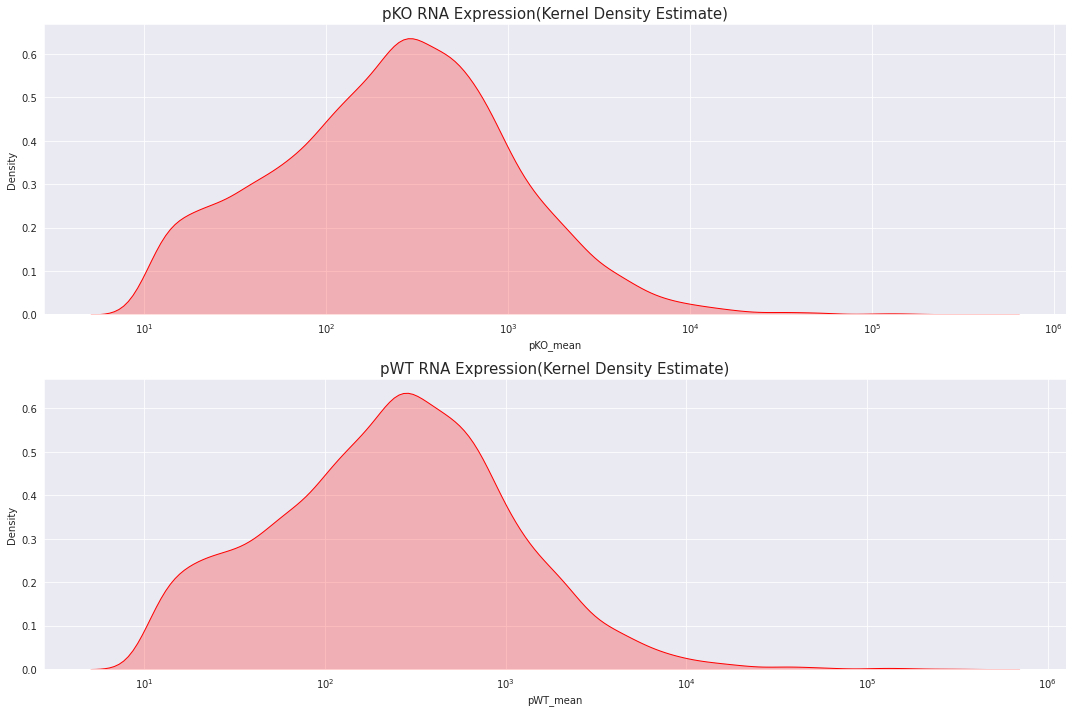

In [221]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), tight_layout=True)

sns.set_style('darkgrid')

_ = sns.kdeplot(df_mouse['pKO_mean'], fill=True, color='r', ax=axs[0], label='pKO RNA Expression', log_scale=True)
_ = axs[0].set_title('pKO RNA Expression(Kernel Density Estimate)', fontsize=15)

_ = sns.kdeplot(df_mouse['pWT_mean'], fill=True, color='r', ax=axs[1], label='pWT RNA expression', log_scale=True)
_ = axs[1].set_title('pWT RNA Expression(Kernel Density Estimate)', fontsize=15)

In [222]:
#df_mouse.sort_values(by='pWT_div_by_pKO', ascending=False).head(20)

,Gene,pKO_1,pKO_2,pKO_3,pWT_1,pWT_2,pWT_3,pKO_mean,pKO_std,pWT_mean,pWT_std,t_stat,p_val,pKO_div_by_pWT,pWT_div_by_pKO
7050,Odf3l2,107,52,41,98,552,252,63.666667,30.237945,289.222222,246.285366,-1.735228,0.157715,0.220131,4.542757
4321,Gata5,43,27,22,33,137,46,27.333333,5.507571,70.111111,58.674558,-1.240372,0.282623,0.389857,2.565041
1145,Arrdc2,786,337,176,433,1072,854,315.333333,129.862748,747.111111,389.493308,-1.350177,0.248299,0.422070,2.369274
10395,Tnfsf18,6,14,11,37,116,6,20.666667,14.224392,47.555556,59.726537,-1.299643,0.263563,0.434579,2.301075
7486,Prima1,138,49,57,95,319,70,67.000000,24.576411,152.000000,144.634021,-0.951109,0.395407,0.440789,2.268657
5695,Lrp2,53,12,17,29,73,28,19.333333,8.736895,40.111111,28.810363,-0.813442,0.461611,0.481994,2.074713
3898,Gck,168,35,75,108,271,108,72.666667,36.555893,150.555556,105.793475,-1.038042,0.357877,0.482657,2.071865
6868,Mss51,445,430,377,699,1619,981,502.000000,172.652831,1034.000000,560.382905,-2.500225,0.066751,0.485493,2.059761
6939,Myrf,87,50,37,62,190,59,49.666667,12.503333,99.555556,78.466081,-0.999282,0.374210,0.498884,2.004474
4256,Gabrr2,14,17,7,12,39,20,12.000000,5.000000,23.666667,13.868429,-1.288434,0.267070,0.507042,1.972222


## 遺伝子ごとに比較。
KOで多くなる遺伝子って、ほとんどが3倍という

WTでおおくなる遺伝子は、多くて8倍。あとは、ほぼ3倍程度。

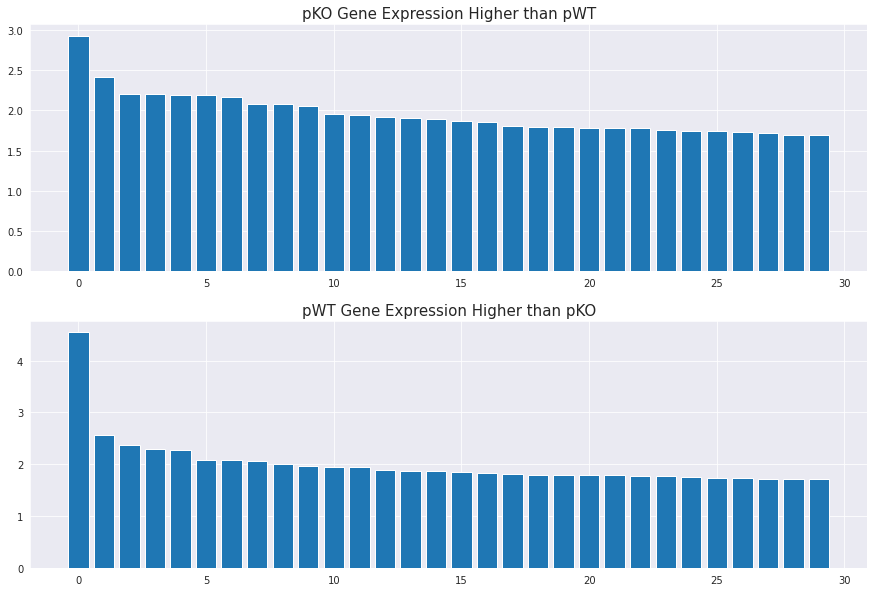

In [223]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.set_style('darkgrid')

_ = axs[0].bar(x=range(30), height=Data_pKO_high)
_ = axs[0].set_title('pKO Gene Expression Higher than pWT', fontsize=15)

_ = axs[1].bar(x=range(30), height=Data_pWT_high)
_ = axs[1].set_title('pWT Gene Expression Higher than pKO', fontsize=15)

plt.show()

In [229]:
display(df_mouse.sort_values(by='p_val', ascending=True).head(20))

,Gene,pKO_1,pKO_2,pKO_3,pWT_1,pWT_2,pWT_3,pKO_mean,pKO_std,pWT_mean,pWT_std,t_stat,p_val,pKO_div_by_pWT,pWT_div_by_pKO
8506,Rassf7,5,6,7,20,20,17,11.000000,7.810250,16.000000,4.582576,-11.258330,0.000355,0.687500,1.454545
4482,Gins1,34,35,32,55,54,50,40.666667,12.503333,48.222222,6.842135,-10.960970,0.000394,0.843318,1.185792
2872,Ctgf,2918,2838,3546,5954,5443,5622,4112.666667,1633.461764,5059.222222,824.612524,-9.551818,0.000671,0.812905,1.230156
3776,Dok1,67,61,65,92,98,88,72.666667,16.862186,86.222222,12.759891,-8.334936,0.001132,0.842784,1.186544
10647,Tspo,1292,1114,1269,2131,2384,2025,1504.666667,547.929132,1971.222222,442.126469,-7.940524,0.001362,0.763317,1.310072
6958,Odf3l1,31,37,43,66,72,65,48.666667,15.307950,61.888889,11.973737,-7.486854,0.001702,0.786355,1.271689
3197,Cyp4f18,67,57,85,154,150,134,98.666667,49.923274,127.555556,26.266441,-7.469156,0.001717,0.773519,1.292793
340,Retnlg,163,108,190,419,348,381,239.000000,161.186228,322.666667,74.312404,-7.231178,0.001940,0.740702,1.350070
11587,Exoc3l,52,69,65,129,110,132,87.666667,35.851546,109.888889,22.166876,-7.179392,0.001994,0.797776,1.253485
7810,Pold1,161,140,143,193,202,199,158.666667,29.771351,186.555556,24.199020,-7.071068,0.002111,0.850506,1.175770


## t検定を追加して、散布図に描写。有意差0.05を基準にして、p値がでるものは色を変更する。

<ipython-input-224-9d745cc205fb>:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = stats.ttest_ind(df_mouse_copy[['pKO_1', 'pKO_2', 'pKO_3']], df_mouse_copy[['pWT_1', 'pWT_2', 'pWT_3']], axis=1, equal_var=True)


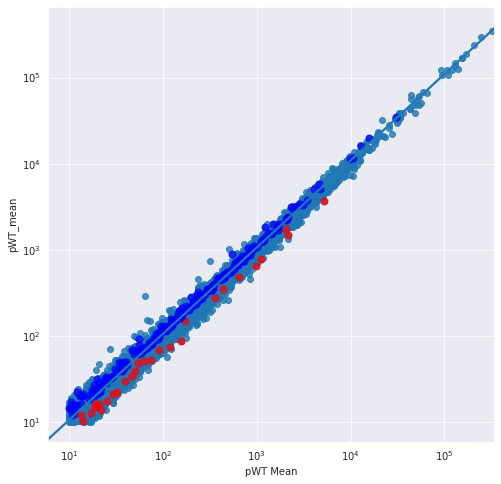

In [224]:
# 遺伝子名をインデックスに設定
df_mouse_copy = df_mouse.copy()

t, p = stats.ttest_ind(df_mouse_copy[['pKO_1', 'pKO_2', 'pKO_3']], df_mouse_copy[['pWT_1', 'pWT_2', 'pWT_3']], axis=1, equal_var=True)
alpha = 0.05

# プロットする
plt.figure(figsize=(8, 8))
  
sns.regplot(x='pKO_mean', y='pWT_mean', truncate=False, data=df_mouse_copy)
plt.xlabel('pKO Mean')
plt.xlabel('pWT Mean')
plt.xscale('log')
plt.yscale('log')
 #sns.regplot(x=mean_a, y=mean_b, fit_reg=False)
 #plt.xlabel('Group A Mean')
 #plt.xlabel('Group A Mean')

# 赤い点と青い点で分けてプロットする
significant_genes = []
for i, gene in enumerate(df_mouse_copy.index):
    if p[i] < alpha:
        if df_mouse['pKO_mean'].iloc[i] > df_mouse_copy['pWT_mean'].iloc[i]:
            plt.scatter(df_mouse_copy['pKO_mean'].iloc[i], df_mouse_copy['pWT_mean'].iloc[i], color='red', s=50, alpha=0.7)
            significant_genes.append((gene, 'pKO'))
        else:
            plt.scatter(df_mouse_copy['pKO_mean'].iloc[i], df_mouse_copy['pWT_mean'].iloc[i], color='blue', s=50, alpha=0.7)
            significant_genes.append((gene, 'pWT'))

In [225]:
print(len(significant_genes))

291


### ECM pathwayに関連した遺伝子のみをつかっていみる。

In [227]:
print(ECMpath[['p_val']].query('p_val <= 0.05').count())
display(ECMpath[['Gene', 'pKO_mean', 'pWT_mean', 'pKO_div_by_pWT', 'p_val']].query('p_val <= 0.05').sort_values(by='p_val'))

p_val    2
dtype: int64


,Gene,pKO_mean,pWT_mean,pKO_div_by_pWT,p_val
10411,Tnc,2343.000000,3178.666667,0.737102,0.010690
2794,Comp,357.333333,273.444444,1.306786,0.041394


In [210]:
ECMpath_peri = ECMpath[['Gene', 'pKO_mean', 'pWT_mean', 'pKO_div_by_pWT', 'p_val']].query('p_val <= 0.05')
ECMpath_peri = ECMpath_peri.query('pKO_div_by_pWT >= 2 or pKO_div_by_pWT <= 0.5')
ECMpath_peri

,Gene,pKO_mean,pWT_mean,pKO_div_by_pWT,p_val
